In [1]:
# Yolo imports
from __future__ import division
import torch 
import torch.nn as nn
import torch.nn.functional as F 
from torch.autograd import Variable
import numpy as np
import cv2 
import time
import argparse
import os 
import os.path as osp
import pickle as pkl
import pandas as pd
import random
from skimage import io
from matplotlib import pyplot as plt
from ConfidenceThresholdingAndNonMaximumSuppression import *
from NeuralNetwork import *
from Utilities import *

#########################################################################################################################


# Lane detection and distance estimation imports
import glob
from skimage import io, data
import matplotlib.image as mpimg
import camera_calibration
import lane_detection
import vanishing_point
#import utilities
import perspective_transform

# YOLO code to be run only once ########################################################################################

#Driver values

images = 'imgs/'
batch_size = 1
confidence = 0.5
nms_thesh = 0.4
start = 0
weights_file = 'yolov3.weights'
cfg_file = 'cfg/yolov3.cfg'

# weights_file = 'yolov3-tiny.weights'
# cfg_file = 'cfg/yolov3-tiny.cfg'


reso = 288
# reso = 416
det = 'det/'
CUDA = torch.cuda.is_available()

num_classes = 80    #For COCO
classes = load_classes("data/coco.names")

######

#Set up the neural network
print("Loading network.....")
model = Darknet(cfg_file)
model.load_weights(weights_file)
print("Network successfully loaded")

model.net_info["height"] = reso
inp_dim = int(model.net_info["height"])
assert inp_dim % 32 == 0 
assert inp_dim > 32

#If there's a GPU availible, put the model on GPU
if CUDA:
    model.cuda()

#Set the model in evaluation mode
model.eval()

#########################################################################################################################

# Lane detection and distance estimation code to be run only once

ret, mtx, dist, rvecs, tvecs = camera_calibration.calibrate(False)

#########################################################################################################################

# YOLO prediction function
# Takes BGR image and returns: 1) image annotated with bounding boxes, 2) list of top left and bottom right
# coordinates of bounding boxes, 3) list of class numbers which correspond to class labels

def get_pred(img):
    read_dir = time.time()
    #Detection phase
    imlist = ['img']

    if not os.path.exists(det):
        os.makedirs(det)

    load_batch = time.time()
    loaded_ims = [np.array(img)]
#     loaded_ims = [cv2.undistort(np.array(img), mtx, dist, None, mtx)]
    
    #PyTorch Variables for images
    im_batches = list(map(prep_image, loaded_ims, [inp_dim for x in range(len(imlist))]))

    #List containing dimensions of original images
    im_dim_list = [(x.shape[1], x.shape[0]) for x in loaded_ims]
    im_dim_list = torch.FloatTensor(im_dim_list).repeat(1,2)

    if CUDA:
        im_dim_list = im_dim_list.cuda()

    leftover = 0
    if (len(im_dim_list) % batch_size):
        leftover = 1

    if batch_size != 1:
        num_batches = len(imlist) // batch_size + leftover            
        im_batches = [torch.cat((im_batches[i*batch_size : min((i +  1)*batch_size, len(im_batches))]))  for i in range(num_batches)]  

    write = 0
    start_det_loop = time.time()
    
    for i, batch in enumerate(im_batches):
        #load the image 
        start = time.time()
        t = time.time()  
        if CUDA:
            batch = batch.cuda()
        with torch.no_grad():
            prediction = model(Variable(batch), CUDA)
#         print("prediction: " , time.time()-t)    
        t = time.time()    
        prediction = write_results(prediction, confidence, num_classes, nms_conf = nms_thesh)
        end = time.time()

        if type(prediction) == int:

            for im_num, image in enumerate(imlist[i*batch_size: min((i +  1)*batch_size, len(imlist))]):
                im_id = i*batch_size + im_num
#                 print("{0:20s} predicted in {1:6.3f} seconds".format(image.split("/")[-1], (end - start)/batch_size))
#                 print("{0:20s} {1:s}".format("Objects Detected:", ""))
#                 print("----------------------------------------------------------")
            continue

        prediction[:,0] += i*batch_size    #transform the atribute from index in batch to index in imlist 
    
    try:
        if not write:                      #If we have't initialised output
            output = prediction  
            write = 1
        else:
            output = torch.cat((output,prediction))

        for im_num, image in enumerate(imlist[i*batch_size: min((i +  1)*batch_size, len(imlist))]):
            im_id = i*batch_size + im_num
            objs = [classes[int(x[-1])] for x in output if int(x[0]) == im_id]
#             print("{0:20s} predicted in {1:6.3f} seconds".format(image.split("/")[-1], (end - start)/batch_size))
#             print("{0:20s} {1:s}".format("Objects Detected:", " ".join(objs)))
#             print("----------------------------------------------------------")

        if CUDA:
            torch.cuda.synchronize()
#         output
    except:
        #print("exception")
        return loaded_ims[0]

    im_dim_list = torch.index_select(im_dim_list, 0, output[:,0].long())

    scaling_factor = torch.min(inp_dim/im_dim_list,1)[0].view(-1,1)

    output[:,[1,3]] -= (inp_dim - scaling_factor*im_dim_list[:,0].view(-1,1))/2
    output[:,[2,4]] -= (inp_dim - scaling_factor*im_dim_list[:,1].view(-1,1))/2

    output[:,1:5] /= scaling_factor

    for i in range(output.shape[0]):
        output[i, [1,3]] = torch.clamp(output[i, [1,3]], 0.0, im_dim_list[i,0])
        output[i, [2,4]] = torch.clamp(output[i, [2,4]], 0.0, im_dim_list[i,1])

    class_load = time.time()
    colors = pkl.load(open("pallete", "rb"))

    draw = time.time()

    list(map(lambda x: write_img(x, loaded_ims, color = random.choice(colors), classes = classes), output))

    t = time.time()
    det_names = pd.Series(imlist).apply(lambda x: "{}/det_{}".format(det,x.split("/")[-1]))
    
    end = time.time()
    
#     print("SUMMARY")
###     print("----------------------------------------------------------")
###     print("{:25s}: {}".format("Task", "Time Taken (in seconds)"))
###     print()
###     print("{:25s}: {:2.3f}".format("Reading addresses", load_batch - read_dir))
###     print("{:25s}: {:2.3f}".format("Loading batch", start_det_loop - load_batch))
###     print("{:25s}: {:2.3f}".format("Drawing Boxes", end - draw))
#     print("{:25s}: {:2.3f}".format("Average time_per_img", (end - load_batch)/len(imlist)))
#     print("----------------------------------------------------------")

#     t = time.time()
#     torch.cuda.empty_cache()
#     print('= Time to torch.cuda.empty_cache : ', time.time() - t)
   
    return loaded_ims[0], output[:, 1:3], output[:, 3:5], output[:, -1]

#########################################################################################################################

# Perspective transform function.
# Takes as input: 1) BGR image, 2) debug mode, 3) YOLO annotated image
# Returns: 1) Homography matrix, 2) x pixels per meter, 3) y pixels per meter
# To be called only one time one time on a base image, its outputs are then used for any image

def driver_perspective_transform(img_BGR, debug=False):
#     ud_img_BGR = cv2.undistort(img_BGR, mtx, dist, None, mtx)
    ud_img_BGR = img_BGR
    ud_img_RGB = cv2.cvtColor(ud_img_BGR, cv2.COLOR_BGR2RGB)
    if(debug):
        show_images([ud_img_RGB])
    detector = lane_detection.LaneDetector()
    lines = detector.process(ud_img_RGB, True, 0.16, debug)
    
    vp = vanishing_point.calculate_vanishing_point(lines, ud_img_BGR, debug)
    
    H, H_inv, warped = perspective_transform.perspective_transform(vp, ud_img_BGR, debug)
    
    x_pixels_per_meter , y_pixels_per_meter, left_low, left_high, right_low, right_high = \
                    perspective_transform.get_ratio(H, H_inv, warped, mtx, debug)

    return H, x_pixels_per_meter, y_pixels_per_meter

#########################################################################################################################

# Distance estimation function
# Takes as input: 1) Query pixel, 2) Bottom center coordinates of screen, 3) homography matrix,
# 4) x pixels per meter, 5) y pixels per meter
# Returns distance to the query pixel
def get_distance(query_pnt, center, H, x_pixels_per_meter, y_pixels_per_meter):
    return perspective_transform.get_distance(query_pnt, center, H, x_pixels_per_meter, y_pixels_per_meter)

#######################################################################################################################

Loading network.....
Network successfully loaded


In [2]:
##Calculating relative velocities and accelerations from distances values, and checking for emergency brake

import math
import threading
import time

dist = 0
rel_vel = 0
rel_acc = 0
t = time.time()

def Brake2Secs():
    BADAS_fns.StartFullBrake()
    time.sleep(3)
    BADAS_fns.StopBrake()

def BrakeDecide(new_dist):
    global dist
    global rel_vel
    global rel_acc
    global t
    
#     test using actual distance exctract from sim
#     packet = BADAS_fns.client.getAdasPacket()  
#     new_dist = packet[1]

    rel_vel_tmp = ( dist - new_dist ) / (time.time() - t)
    rel_acc = ( rel_vel - rel_vel_tmp) / (time.time() - t)
    
#     test w/o quadtratic eq
#     rel_acc = 0

    rel_vel = rel_vel_tmp
    dist = new_dist
    
    print('distance = ' , dist )
    print('rel_vel = ' , rel_vel )
    print('rel_acc = ' , rel_acc )
    print('rel time = ' , time.time() - t )
    t = time.time()
    
#     if(new_dist > 60):
#         print('Brake = 0')
#         return False
    
    if VisionEmergencyCheck(rel_acc,rel_vel,dist):
        print('Brake = 1')
        threading.Thread(target=Brake2Secs).start()
        return True
    else:
        print('Brake = 0')
        return False
    
def ThresholdCheck(T):
    print('T for collision: ', T)
    if(T <= 0.7 and T > 0):
        if( T < 1 and T > 0.2 ):
            ManueverRight()
        return True
    return False

# a: 0.5 * acc
# b: vel
# c: -distance
def VisionEmergencyCheck(acc, vel, dist):
    if( vel < 0.001):
        return False
    
    if( acc == 0 ):
        return ThresholdCheck(dist/vel)
    else:
        a = 0.5 * acc
        b = vel
        c = -dist
        
        d = (b**2) - (4*a*c)
        if(d<0):
#             print('No collision (d<0)')
            return False
        
        T = (-b+math.sqrt(d))/(2*a)
        return ThresholdCheck(T)

# while True:
#     time.sleep(0.1)
#     BrakeDecide(0)
# BADAS_fns.StopBrake()

In [3]:
# Sim Real-time distance detection and showing output using CV2
# import numpy

##################################################################################################################################################################

# Importing Airsim and connecting
# Uses local airsim package (DO NOT pip install, UNINSTALL IF INSTALLED ALREADY: "pip uninstall airsim")
from pathlib import Path
import sys
import os
from ctypes import *
sys.path.append(str(Path().resolve().parent.parent).replace('\\','/') + '/AirSimClient')
os.environ['PATH'] = str(Path().resolve().parent.parent).replace('\\','/') + '/AirSimClient' + os.pathsep + os.environ['PATH']
d = CDLL('SDL2.dll')
import BADAS_fns
BADAS_fns.Find_BADAS_Client()
time.sleep(0.5)
BADAS_fns.client.confirmConnection()

def GetSimImg():
    responses = BADAS_fns.client.simGetImages([ BADAS_fns.airsim.ImageRequest("0", BADAS_fns.airsim.ImageType.Scene, False, False) ])
    response = responses[0]
    img1d = np.fromstring(response.image_data_uint8, dtype=np.uint8) 
    img = img1d.reshape(response.height, response.width, 4)  
    return cv2.cvtColor(img, cv2.COLOR_RGB2BGR)


##################################################################################################################################################################

# Preparing text style that will be used in writing distances
font                   = cv2.FONT_HERSHEY_SIMPLEX
pos = (0,0)
fontScale              = 1
fontColor              = (255,255,255)
lineType               = 2

while True:
    # Press "q" to quit
    if cv2.waitKey(25) & 0xFF == ord("q"):
        cv2.destroyAllWindows()
        break

    t1 = time.time()
    img = GetSimImg()
    
#     img = GetMonitorImg()
    print('T Sim image extract: ' , time.time() - t1)
        
#     with mss.mss() as sct:
#         monitor = {"top": 0, "left": 0, "width": 1920, "height": 1040}
#         img = numpy.array(sct.grab(monitor))
        
    # Image bottom center coordinates
    center = [img.shape[1]//2, img.shape[0]-1]

    # Getting predictions from yolo
    try:
        t1 = time.time()
        pred, top_left, bottom_right, labels = get_pred(img)
        print('T Yolo: ' , time.time() - t1)
    except:
        print('Yolo Exception ')
        cv2.imshow("", img)
        continue
        
    try:    
        # Perform perspective transform and annotate yolo image
        t1 = time.time()
        H, x_pixels_per_meter, y_pixels_per_meter = driver_perspective_transform(img, pred, False)
        print('T driver_perspective_transform: ' , time.time() - t1)
    except Exception as e:
#         print('Lane detection Exception ')
#         print(e)
        cv2.imshow("", pred)
        continue
    
    t1 = time.time()
    # Looping on every detected object
    for i in range(len(labels)):
        # Object label
        label = classes[int(labels[i])]

        if(label != "car"):
            continue

        # Top left x,y
        tlx, tly = int(top_left[i,0]), int(top_left[i,1])

        # Bottom right x,y
        brx, bry = int(bottom_right[i,0]), int(bottom_right[i,1])

        # Bottom center coordinates of bounding box
        cx, cy = (tlx + brx)//2, bry

        #print(str(cx) + "," + str(cy) + " | " + str(center[0]) + "," + str(center[1]))

        # Distance to car
        float_dist = get_distance([cx, cy], center, H, x_pixels_per_meter, y_pixels_per_meter)
        EmergencyBool = BrakeDecide(float_dist)

        distance = str(round_float(float_dist))+"m"
        
        if(EmergencyBool):
            # Annotate yolo image with distance to car
            cv2.putText(pred,
                "EMERGENCY",
                (cx-60, cy-60), 
                font, 
                fontScale,
                fontColor,
                lineType)
       # Annotate yolo image with distance to car
        cv2.putText(pred,
        distance,
        (cx-60, cy+30), 
        font, 
        fontScale,
        fontColor,
        lineType)

        print('T Get distance: ' , time.time() - t1)
        
    #print(x_pixels_per_meter)
    #print(y_pixels_per_meter)
    #print(time.time() - t)
    cv2.imshow("", pred)
    #show_images([cv2.cvtColor(pred, cv2.COLOR_BGR2RGB)])

OSError: [WinError 126] The specified module could not be found

(500, 1200, 3)


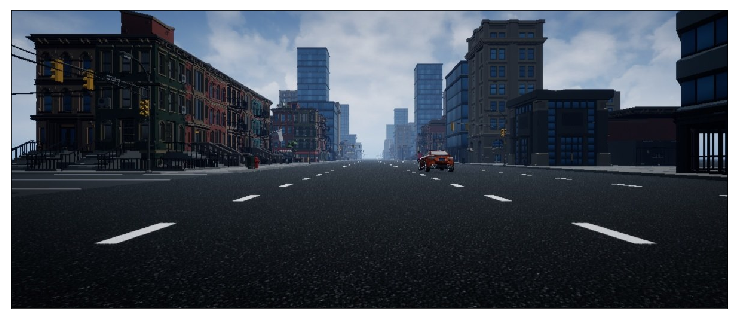

after white color selection


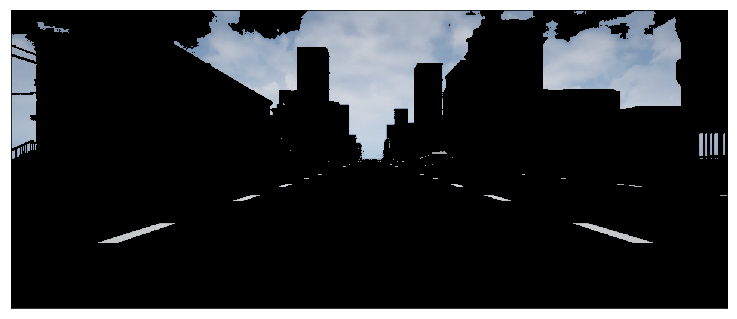

after converting to grayscale


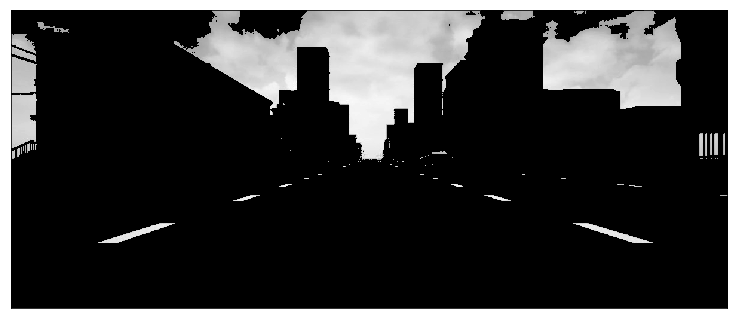

after smoothing


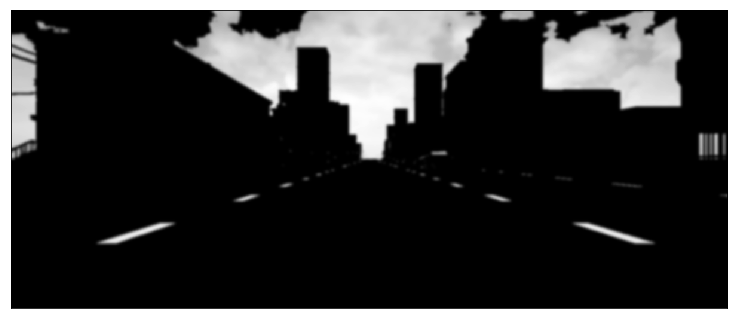

after edge detection


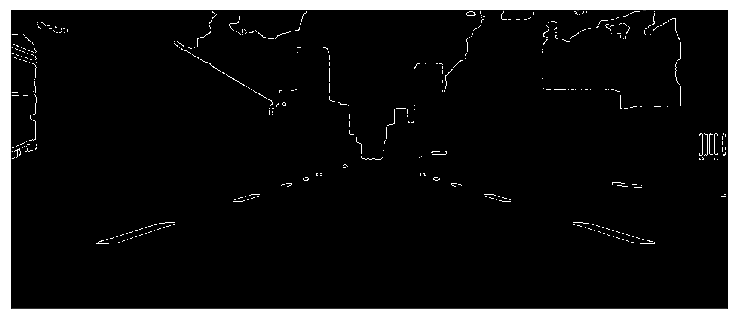

after ROI


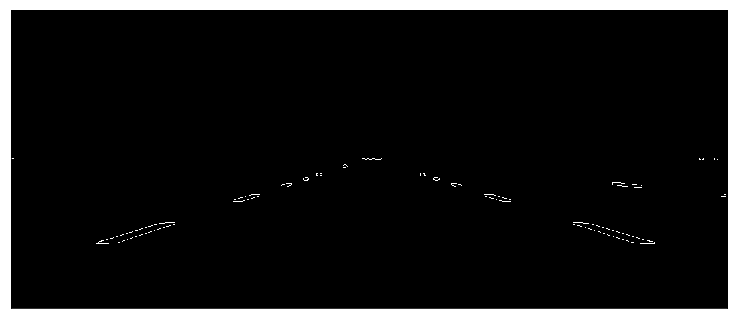

[[598]
 [250]]


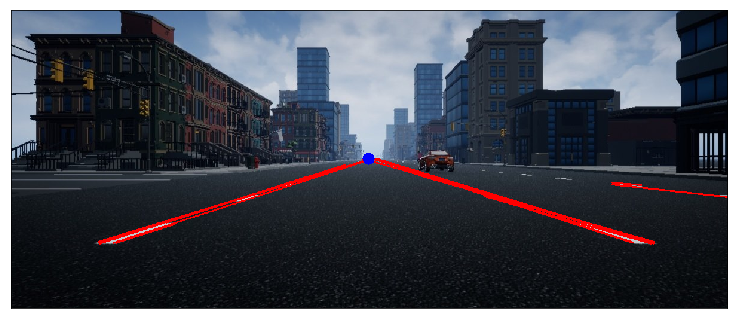

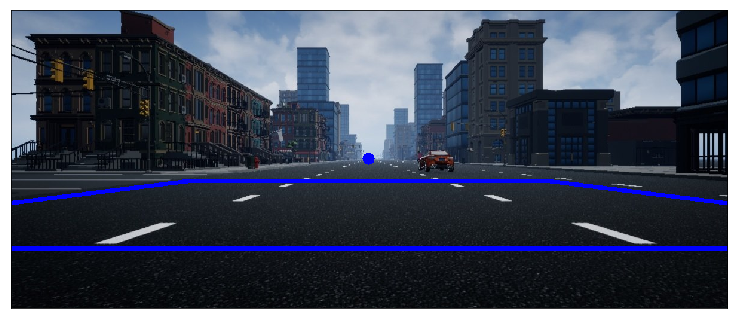

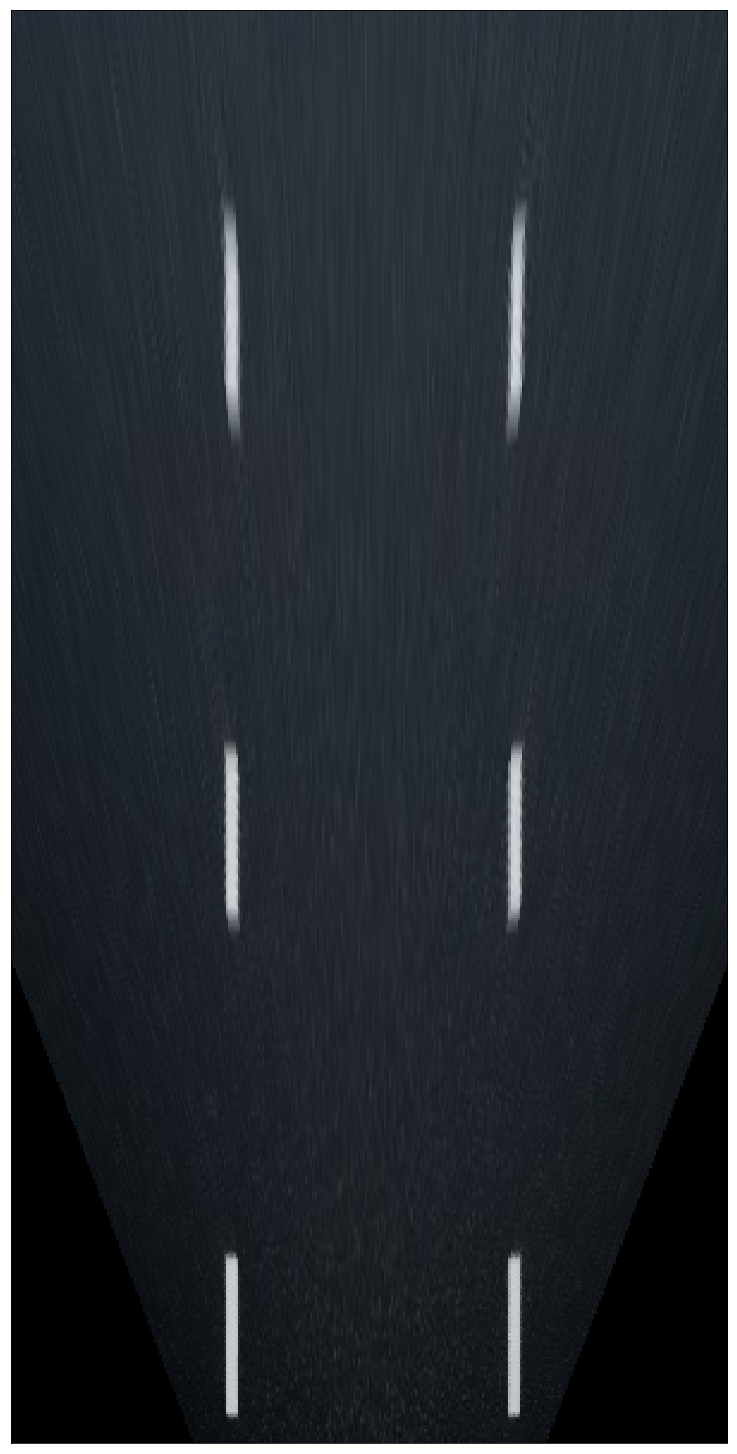

after white color selection


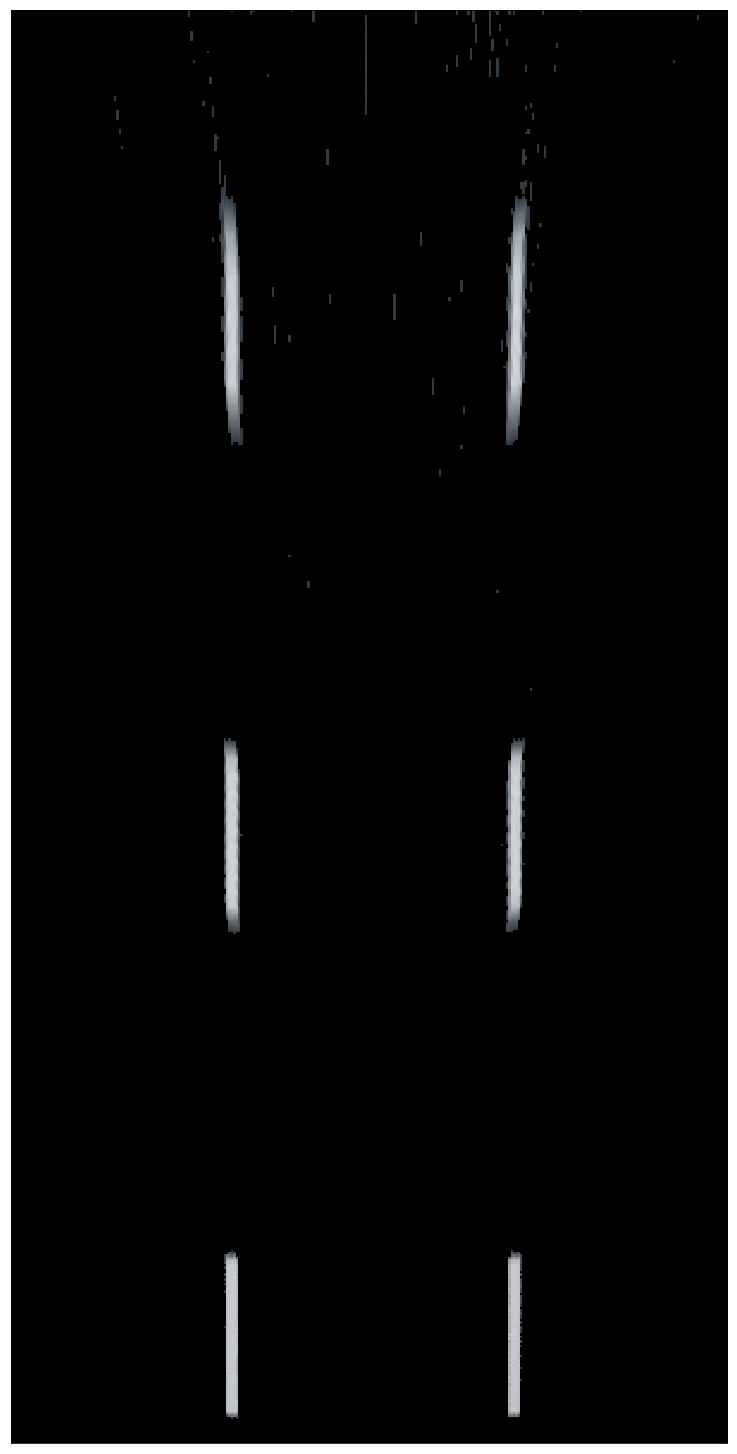

after converting to grayscale


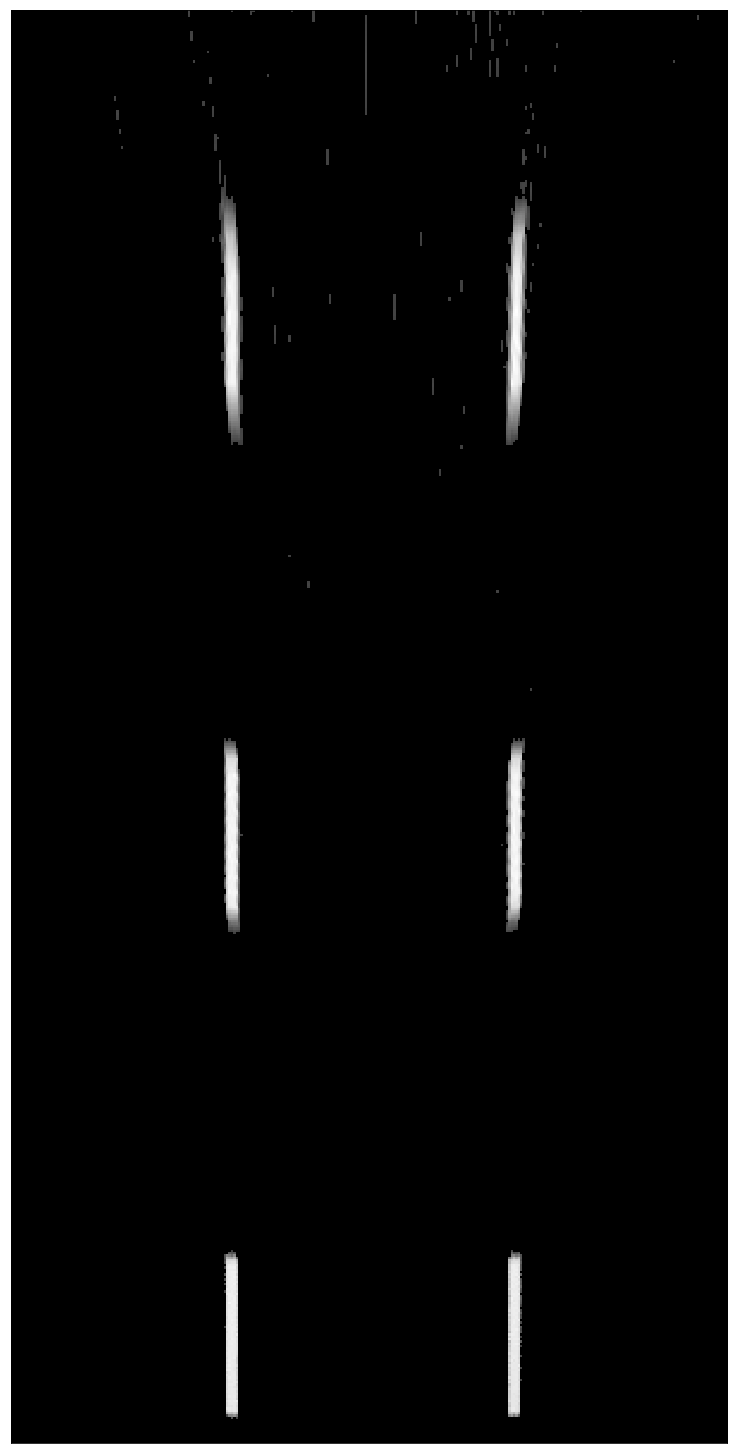

after smoothing


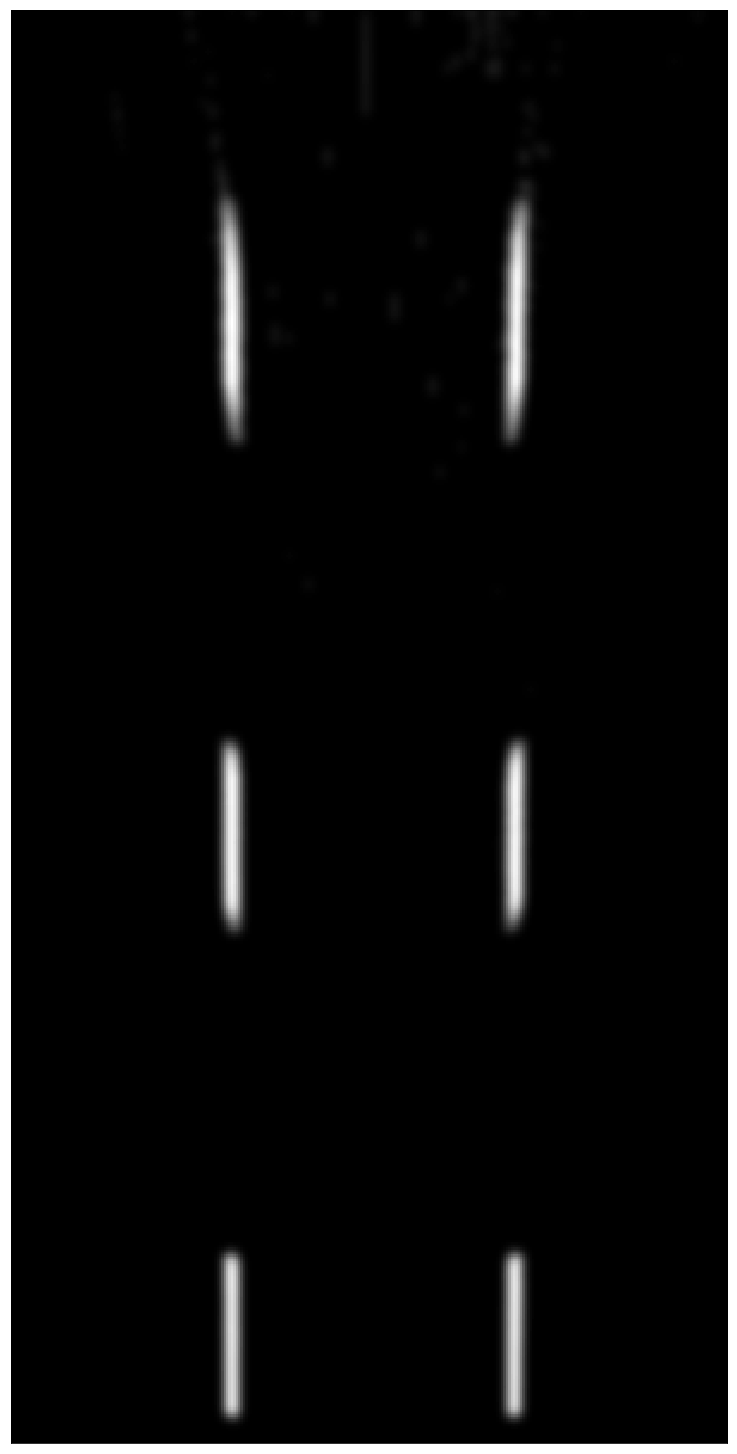

after edge detection


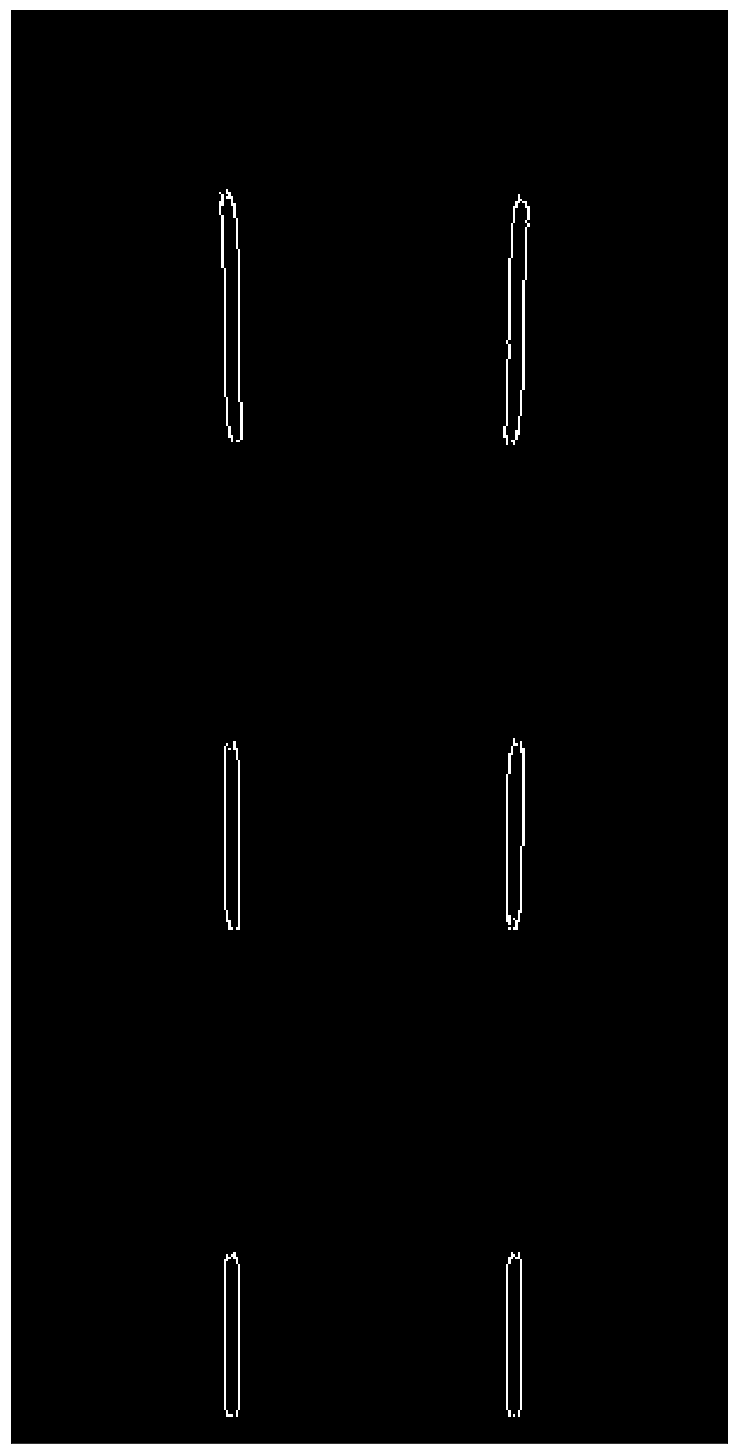

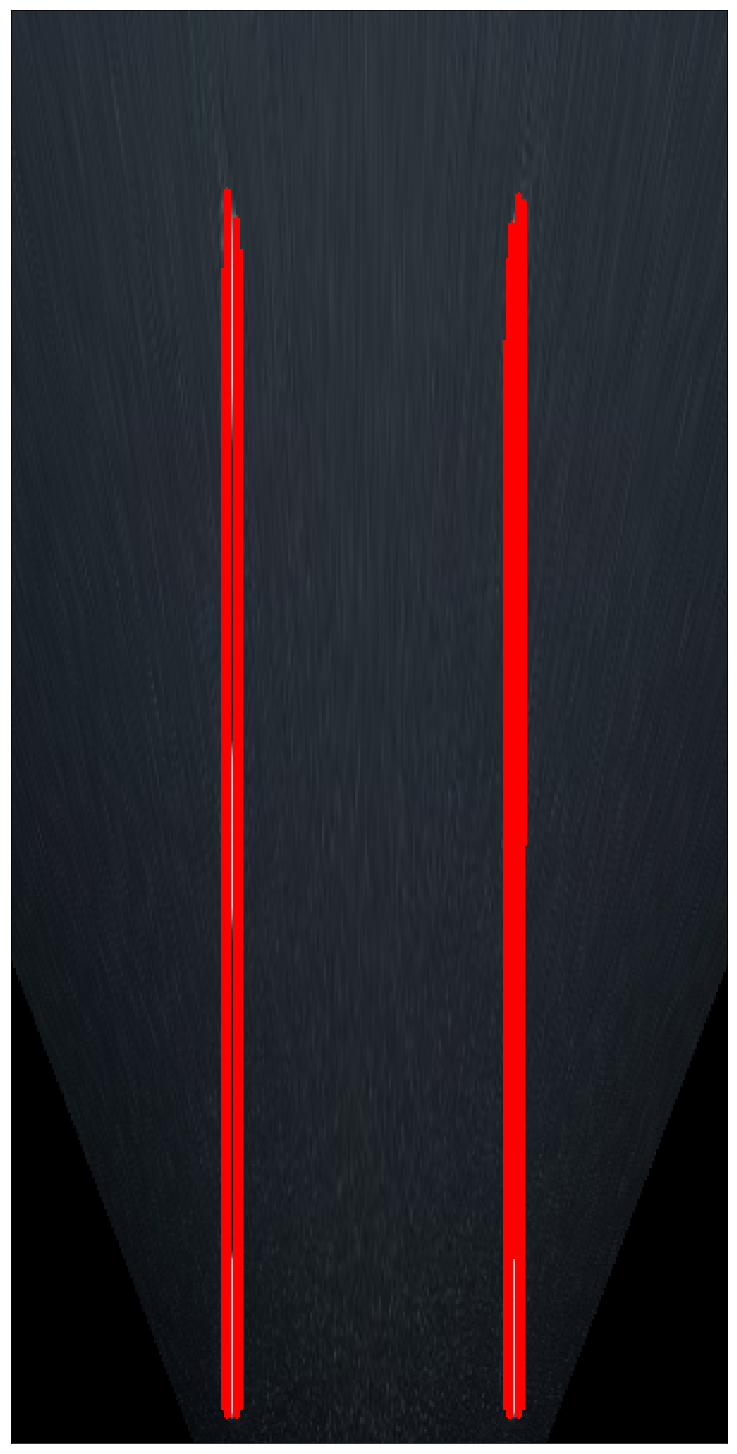

pxls/mtr: 32.26159333333333,43.953951728911115
714,274 | 600,499
32.26159333333333
43.953951728911115


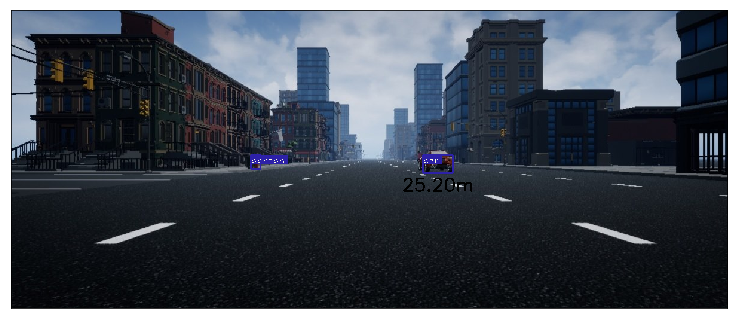

In [4]:
# Reading image
img = cv2.imread('imgs/noshade1200x500.JPG')

print(img.shape)

# Image bottom center coordinates
center = [img.shape[1]//2, img.shape[0]-1]

# Preparing text style that will be used in writing distances
font                   = cv2.FONT_HERSHEY_SIMPLEX
pos = (0,0)
fontScale              = 1
fontColor              = (0,0,0)
lineType               = 2

# Getting predictions from yolo
pred, top_left, bottom_right, labels = get_pred(img)
    
# Perform perspective transform and annotate yolo image
H, x_pixels_per_meter, y_pixels_per_meter = driver_perspective_transform(img, True)
    
# Looping on every detected object
for i in range(len(labels)):
    
    # Object label
    label = classes[int(labels[i])]
    
    if(label != "car"):
        continue
        
    # Top left x,y
    tlx, tly = int(top_left[i,0]), int(top_left[i,1])
    
    # Bottom right x,y
    brx, bry = int(bottom_right[i,0]), int(bottom_right[i,1])
        
    # Bottom center coordinates of bounding box
    cx, cy = (tlx + brx)//2, bry
    
    print(str(cx) + "," + str(cy) + " | " + str(center[0]) + "," + str(center[1]))
    
    # Distance to car
    float_dist = get_distance([cx, cy], center, H, x_pixels_per_meter, y_pixels_per_meter)

    distance = str(round_float(float_dist))+"m"
    
    # Annotate yolo image with distance to car
    cv2.putText(pred,
        distance,
        (cx-60, cy+30), 
        font, 
        fontScale,
        fontColor,
        lineType)

print(x_pixels_per_meter)
print(y_pixels_per_meter)
    
show_images([cv2.cvtColor(pred, cv2.COLOR_BGR2RGB)])

In [6]:
# Annotates image with lanes or prints on image that lane departure is detected
# Inputs: 1) image, 2) resolution of image / 1200x500 resolution
# Outputs: 2) Annotated image

def get_lane_image(img, ratio):

    base_left_m, base_left_c, base_right_m, base_right_c = -0.32785089597153977, 446.0614062879984*ratio,\
                                                            0.2911316010810115, 79.62376483613377*ratio
    max_m_diff, max_c_diff = 0.05, 20

    test_img = np.array(img)
    width, height = test_img.shape[1], test_img.shape[0]

    detector = lane_detection.LaneDetector()
    lines = detector.process(cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB), True, 0.2, False)

    left_lane_lines, right_lane_lines = lane_detection.get_lane_lines(lines, base_left_m, base_left_c, base_right_m,
                                                                      base_right_c, max_m_diff, max_c_diff)
    if(len(left_lane_lines)==0 or len(right_lane_lines)==0):
        cv2.putText(test_img,
            "Not between 2 lanes",
            (int(width/2-150), 50), 
            font, 
            fontScale,
            fontColor,
            lineType)
    else:
        left_lane_line, right_lane_line = get_lines_mean(left_lane_lines), get_lines_mean(right_lane_lines)
        low_y, high_y = height-1, int(height * 0.6)
        left_low, left_high = (int((low_y-left_lane_line[1])/left_lane_line[0]), low_y),\
                              (int((high_y-left_lane_line[1])/left_lane_line[0]), high_y)
        right_low, right_high = (int((low_y-right_lane_line[1])/right_lane_line[0]), low_y),\
                              (int((high_y-right_lane_line[1])/right_lane_line[0]), high_y)
        cv2.line(test_img, tuple(left_low), tuple(left_high),(0,0,255),5)
        cv2.line(test_img, tuple(right_low), tuple(right_high),(0,0,255),5)
    
    return test_img

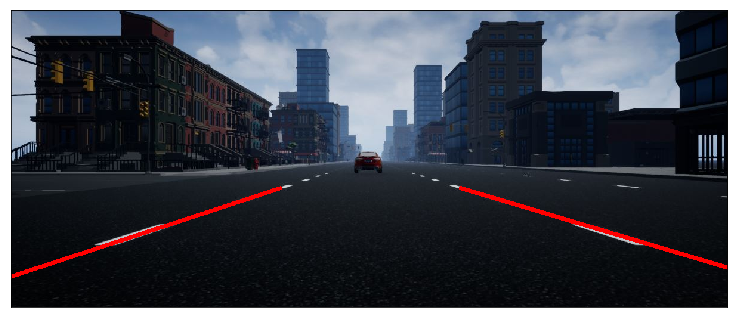

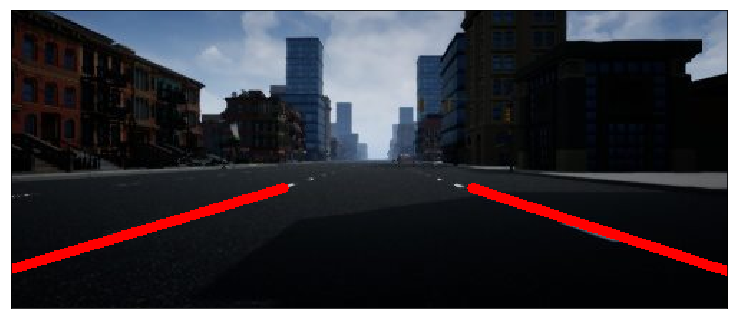

In [10]:
test_img1 = cv2.imread('imgs/1202x498.jpg')
out_img1 = get_lane_image(test_img1, 1)
show_images([cv2.cvtColor(out_img1, cv2.COLOR_BGR2RGB)])

test_img2 = cv2.imread('imgs/manyshade500x208.jpg')
out_img2 = get_lane_image(test_img2, 500/1200.0)
show_images([cv2.cvtColor(out_img2, cv2.COLOR_BGR2RGB)])


In [ ]:
def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / np.linalg.norm(vector)

def angle_between(v1, v2):
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))

#BADAS v2.6+
def SteerByAngle(angle, direction):
    
    FirstVec = BADAS_fns.client.getSuvFwdVec() #Get first forward vector
    
    car_controls = BADAS_fns.airsim.CarControls()
    
    car_controls.throttle = 0 # Change later, need to meet certain velocity depending on manuever equation
    
    if(direction == 'right'):
        car_controls.steering = 1
    elif(direction == 'left'):
        car_controls.steering = -1
        
    #Start steering    
    BADAS_fns.client.enableApiControl(True)  
    BADAS_fns.client.setCarControls(car_controls)
    
    #Keep steering until required angle is met
    while (True):
        SecVec = BADAS_fns.client.getSuvFwdVec()
        radians = angle_between( (FirstVec['X'], FirstVec['Y']), (SecVec['X'], SecVec['Y'])) #Get angle betwen first and second forward vectors
        
        if(math.degrees(radians) >= angle): #Stop steering if required angle is met
            break
        
        if(BADAS_fns.client.getCarState().speed < 1): #Stop steering in case of errors
            break
            
        time.sleep(0.01)
        
    BADAS_fns.client.enableApiControl(False) # Return driver full controls

def ManueverRight():
    SteerByAngle(20,'right')
    time.sleep(0.1)   
    SteerByAngle(20,'left')

In [ ]:
try:
    while True:
        #starttime = time.time()
        t = time.time()
        responses = client.simGetImages([ airsim.ImageRequest("0", airsim.ImageType.Scene, False, False) ])
        response = responses[0]
        img1d = np.frombuffer(response.image_data_uint8, dtype=np.uint8) 
        img_rgba = img1d.reshape(response.height, response.width, 4)  
        img_rgba = cv2.resize(img_rgba, dsize=(256, 128), interpolation=cv2.INTER_NEAREST) #####################RESIZING FOR FAST PREDICTION
        print('= T Extract sim image: ' , time.time()-t)

        t = time.time()
        detected = get_pred(img_rgba)
        print('= T Detecting: ' , time.time()-t)
        
        cv2.imshow("img", detected)
        #print('=== TOTAL TIME ' , time.time()-starttime , ' ===\n')
        
        if cv2.waitKey(25) & 0xFF == ord("q"):
            cv2.destroyAllWindows()
            break
except:
    cv2.destroyAllWindows()

In [ ]:
import time
x = 100
while True:
    x = x -1
    if x < 0:
        break
    t = time.time()
    png_image = client.simGetImage("1", airsim.ImageType.Scene)
    print('time: ' , time.time()-t)

In [ ]:
BADAS_fns.Find_BADAS_Client()
time.sleep(0.5)
BADAS_fns.client.confirmConnection()

In [ ]:
responses = BADAS_fns.client.simGetImages([ BADAS_fns.airsim.ImageRequest("0", BADAS_fns.airsim.ImageType.Scene, False, False) ])
response = responses[0]
img1d = np.fromstring(response.image_data_uint8, dtype=np.uint8) 
img = img1d.reshape(response.height, response.width, 4)  
img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

In [ ]:
#Print average of time to detect img and predict
timeout = time.time() + 3 #5 secs

lst = [] 
lst2 = [] 

while True:
    if time.time() > timeout:
        break
    start = time.time()
    responses = BADAS_fns.client.simGetImages([ BADAS_fns.airsim.ImageRequest("0", BADAS_fns.airsim.ImageType.Scene, False, False) ])
    response = responses[0]
    img1d = np.fromstring(response.image_data_uint8, dtype=np.uint8) 
    img = img1d.reshape(response.height, response.width, 4)  
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    print("T SimGetImg =", time.time() - start ) 
    lst2.append(time.time() - start)
    
    start = time.time()
    detected = get_pred(img)
    print("T Yolo =", time.time() - start ) 
    lst.append(time.time() - start)
        
print("AverageGetImage =", sum(lst2) / len(lst2) ) 
print("AverageYolo =", sum(lst) / len(lst) ) 

In [ ]:
#40fps fullscreen quality3 AverageAll = 0.105, AverageGetImage = 0.0021

#over lan 35fps fullscreen quality3
#AverageGetImage = 0.019696117627738725
#AverageAll = 0.09919774414289116

In [ ]:
import time
timeout = time.time() + 5 #5 secs

while True:
    if time.time() > timeout:
        break
    x = 0
    start = time.time()
    while True:
        responses = client.simGetImages([ airsim.ImageRequest("0", airsim.ImageType.Scene, False, False) ])
        response = responses[0]
        #detected = get_pred((np.frombuffer(response.image_data_uint8, dtype=np.uint8) ).reshape(response.height, response.width, 4))
        if(time.time() - start > 1):
            break
        x += 1

    print(x)

In [ ]:
#SHOW ONE IMAEG
png_image = BADAS_fns.client.simGetImage("0", BADAS_fns.airsim.ImageType.Scene)
Image.open(io.BytesIO(png_image)).show()

In [ ]:
import mss
import mss.tools
import time
from PIL import Image

while True:
    
    
    with mss.mss() as sct:
        for num, monitor in enumerate(sct.monitors[1:], 1):
            # Get raw pixels from the screen
            sct_img = sct.grab(monitor)
            # Create the Image
            img = Image.frombytes("RGB", sct_img.size, sct_img.bgra, "raw", "BGRX")

        # Grab the data
        t = time.time()
        sct_img = sct.grab(monitor)
        print(time.time() - t)
        #sct_img.
        #print(type(sct_img))
        # Save to the picture file
        #mss.tools.to_png(sct_img.rgb, sct_img.size, output=output)
        #print(output)

In [ ]:
responses = client.simGetImages([ airsim.ImageRequest("0", airsim.ImageType.Scene, False, False) ])
response = responses[0]
img1d = np.fromstring(response.image_data_uint8, dtype=np.uint8) 
img_rgba = img1d.reshape(response.height, response.width, 4)  
img_RGB = cv2.cvtColor(img_rgba, cv2.COLOR_RGB2BGR)
cv2.imwrite('3.jpg',img_RGB)

In [ ]:
def GetMonitorImg():
    with mss.mss() as sct:
        for num, monitor in enumerate(sct.monitors[1:], 1):
            # Get raw pixels from the screen
            sct_img = sct.grab(monitor)
            # Create the Image
            return Image.frombytes("RGB", sct_img.size, sct_img.bgra, "raw", "BGRX")

In [ ]:
def GetMonitorImg2():
    with mss.mss() as sct:
        monitor = {"top": 0, "left": 0, "width": 1920, "height": 1040}
        img = numpy.array(sct.grab(monitor))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        return img

In [ ]:
t = time.time()
get_pred(img)
print(time.time() - t)